In [46]:
import pandas as pd
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import re
from string import punctuation
import numpy as np
import math
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
from nltk.corpus import wordnet as wn
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import pickle


<p style="font-family:Muro;font-weight:bold;font-size:35px;margin:10px 0px 10px 0px;color:#ADD8E6">Sentiment Analysis</p>

In this section, we explore the happiest, saddest, and most emotionally unstable characters. We will also analyse the character development of some main characters across the seasons, based on their sentiment evolution.

### Processing and utility functions
In this part we load the dataset with the character lines. We make a few functions that we will use later, to extract the total lines per character, the lines per character in every season and for every episode. We also only keep those lines that were actually aired.

In [3]:
script_path = "Data/the-office-lines-script.xlsx"
df_dialog = pd.read_excel(script_path, index_col = "id")

In [4]:
df_dialog

,season,episode,scene,line_text,speaker,deleted
id,,,,,,
1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,False
2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False
3,1,1,1,So you've come to the master for guidance? Is ...,Michael,False
4,1,1,1,"Actually, you called me in here, but yeah.",Jim,False
5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False
...,...,...,...,...,...,...
59905,9,23,112,It all seems so very arbitrary. I applied for ...,Creed,False
59906,9,23,113,I just feel lucky that I got a chance to share...,Meredith,False
59907,9,23,114,I���m happy that this was all filmed so I can ...,Phyllis,False


In [5]:
# We remove the parenthetical. That is, the text into parenthesis that provides directions for the characters.
parentheticals_regex = r"(\[.*?\])"

def remove_parentheticals(line):
    line = str(line)
    parentheticals = re.findall(parentheticals_regex,line)
    
    for parenthetical in parentheticals:
        line = line.replace(parenthetical, "")
    
    return line

In [6]:
def get_character_lines_per_episode(character):

    df_aired_lines = df_dialog.loc[df_dialog.deleted == False]
    df_character = df_aired_lines.loc[df_aired_lines.speaker == character]
    
    character_season_lines = {}

    for season in df_character.season.unique():
        df_season = df_character.loc[df_character.season == season]
        character_episode_lines = {}
        
        for episode in df_season.episode.unique():
            df_episode = df_season.loc[df_season.episode == episode]
        
            character_episode_lines[episode] = [remove_parentheticals(line) for line in list(df_episode.line_text)]
        
        character_season_lines[season] = character_episode_lines
        
    return character_season_lines

In [7]:
def get_character_lines_per_season(character):
    character_season_lines = get_character_lines_per_episode(character)       
    return {season:[line for episode in episodes.values() for line in episode] for (season, episodes) in character_season_lines.items()}

In [8]:
def get_character_lines_series(character):  
    dialog = get_character_lines_per_season(character)
    return [line for season in dialog.values() for line in season]

In [9]:
def un_pack_episode_lines(character):
    episode_lines = get_character_lines_per_episode(character)   
    return {(season,episode):lines for (season,episodes) in episode_lines.items() for (episode,lines) in episodes.items()}
    #return [lines for episode in episode_lines.values() for lines in episode.values()]

In [10]:
df_aired = df_dialog[df_dialog.deleted == False]
characters_dialog = df_aired.speaker.unique()

### Sentiment analysis distribution
We extract the sentiment for every character that has lines. To do so, we compute the sentiment for every sentence that a character has and compute the average sentiment, for every character.

For this, we use VADER, which assigns a sentiment to every phrase between 0 and 1. It takes into account not only the sentiment of the words, but the sentiment of a sentence as a whole, since words have different connotations depending on context. Also takes into account punctuation, which is used to emphasize the meaning of sentences. Therefore, this approach which offers a more accurate sentiment depiction than others.

In [11]:
def get_avg_sentiment_node_VADER(character, avg = True):
    analyzer = SentimentIntensityAnalyzer()
    #character = character.split("_")[0]
    
    total = []

    # otherwise, for each sentence in the character's dialogue
    dialogue = get_character_lines_series(character)
    for sentence in dialogue:
        # compute the polarity score
        vs = analyzer.polarity_scores(sentence)
        total.append(vs["compound"])
    
    if not avg:
        return total
    # return the average sentiment across all sentences in the character's dialogue
    return sum(total)/len(dialogue)

In [12]:
char_sentiment_VADER = {char:get_avg_sentiment_node_VADER(char) for char in characters_dialog}

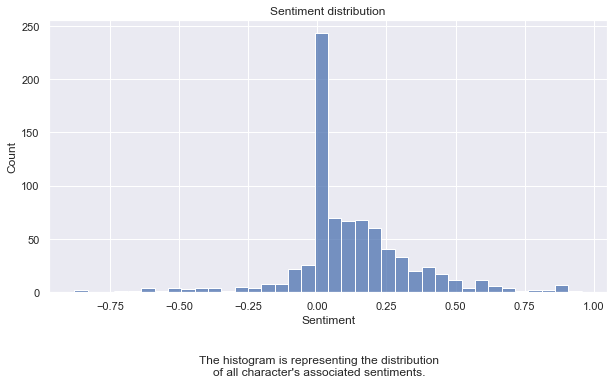

In [13]:
sns.set_theme()
title = "Sentiment distribution"
caption = "The histogram is representing the distribution\nof all character's associated sentiments."
plt.figure(figsize=[10,5])
sns.histplot(char_sentiment_VADER)
plt.title(title)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=12)
#plt.savefig(folder + "sentiment_distribution.png")
plt.show()

In [14]:
 dict(sorted(char_sentiment_VADER.items(), key=lambda item: item[1], reverse = True))

{'Walter & Walter Jr': 0.9571,
 'Ryan and others': 0.8979,
 'Jo Bennett': 0.8908,
 'Angela and Kelly': 0.8856,
 'Office Staff': 0.875,
 'Michael and Erin': 0.875,
 'Woman 1': 0.8747,
 'Michael/Dwight': 0.8687,
 "Hunter's CD": 0.8316,
 'Fred Henry': 0.8176,
 'Darryl and Andy': 0.7964,
 'MIchael': 0.7653,
 "Mr. O'Malley": 0.7351,
 '4th Athlead Employee': 0.6908,
 'White': 0.6808,
 'Teacher': 0.6716000000000001,
 'Andy and Michael': 0.6705,
 'All the Men': 0.6597,
 'Female church member': 0.6597,
 'Senator Liptop': 0.6532333333333334,
 'Soldier': 0.63935,
 'Gym Instructor': 0.6369,
 'Moderator': 0.6363,
 'Offscreen': 0.6124,
 'Automated phone voice': 0.5994,
 'Miss Trudy': 0.5925499999999999,
 'Member': 0.59055,
 'Angel': 0.5859,
 'TV': 0.5859,
 "Erin's Cell Phone": 0.5859,
 'Council': 0.5775,
 'Maguire': 0.5719,
 'Promo Voice': 0.5719,
 'Gideon': 0.57185,
 'DeAgnelo': 0.5696,
 'Co-worker #2': 0.5511,
 'Pastor': 0.548725,
 'Speaker': 0.5413375,
 'Christian Slater': 0.5204,
 'Amy': 0.5182,

In [15]:
df_dialog[df_dialog.speaker == 'Walter & Walter Jr']

,season,episode,scene,line_text,speaker,deleted
id,,,,,,
46814,8,4,40,[singing] May the good lord be with you down e...,Walter & Walter Jr,False


In [16]:
df_dialog[df_dialog.speaker == 'Michael, Pam & Ryan']

,season,episode,scene,line_text,speaker,deleted
id,,,,,,
29361,5,22,13,"U-G-L-Y, you ain't got no alibi! You ugly, huh...","Michael, Pam & Ryan",False


We find that the distribution resembles a right-skewed Gaussian distribution with one peak around 0 specifically for the characters that had too few lines to be placed by the analysis. The majority of characters fall within a neutral sentiment or are generally happy, with a few notable exceptions of particularly unhappy characters. This is appropriate for a comedy like The Office, where the tone is generally comedic and fun.

If we look at the happiest character, we find `Walter & Walter Jr`, Andy's dad and brother, singing a very cheerful song. On the other extreme, we find `Michael`, `Pam` and `Ryan` also synchronously signing the song U.G.L.Y., which is quite negative.
One issue that we see is that many of them are actually several characters. In further work, we would like to split them so that the sentiment for each individual character is more accurate.

### Sentiment for main characters

We will now focus the main characters, individually. For this, we retrieve the names of the main characters, which we have already saved before. Then, we use the sentiments computed for every character in the previous step and visualize them.

In [17]:
df_filepath = "Data/dataframe_characters.csv"
df = pd.read_csv(df_filepath)
main_characters = list(df[df.Category == "Main_Characters"]["Unnamed: 0"])
main_characters = [character.split(" ")[0] for character in main_characters]

C:\Users\blanc\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


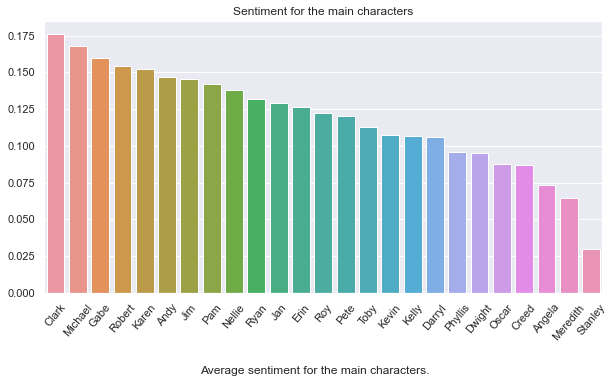

In [18]:
title = "Sentiment for the main characters"
caption = "Average sentiment for the main characters."
plt.figure(figsize=[10,5])
main_char_sentiments = {char:char_sentiment_VADER[char] for char in main_characters}
main_char_sentiments = dict(sorted(main_char_sentiments.items(), key=lambda item: item[1], reverse = True))
x = list(main_char_sentiments.keys())
y = list(main_char_sentiments.values())
sns.barplot(x,y)
plt.title(title)
plt.xticks(rotation=50)
plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig(folder + "sentiment_per_character.png")
plt.show()

We find that Clark, Michael and Gabe are the happiest characters. It doesn't come as a suprise for the bubbly intern Clark, nor for naively optimistic Michael. However, Gabe doesn't come off as a genuinely happy characters, but rather as awkward and restrained in his behavior. Here, we speculate that the dialogue analysis is purely based on word choice and script, rather than the delivery of the words and genuine emotion conveyed. 

On the other side of the spectrum, we have Stanley, Meredith and Angela. Stanley is an obvious character to fall here, as his character is always grumpy. Angela, similarly, is cold and stern, and very rarely shows positivity. Finally, we speculate that Meredith was placed here due to her messy personal life in which she often is victim of unfortunate events. Thus, the sentiments computed seem to be generally accurate.

### Sentiment development of the main characters

Next, we plot the main character´s emotional development throughout the series. We begin by plotting their average sentiment throughout the seasons and examining their evolution. Similar to what we have done before, we compute the sentiment with VADER and then average. But his time we do it for the lines by season. We will focus only Michael, Jim, Dwight, Pam and Andy, since they are the ones [with most lines](https://github.com/nklingen/SocialGraphsProject/blob/main/Data-retrieval-and-analysis.ipynb).

In [19]:
def get_sentiment_season(character):
    season_lines = get_character_lines_per_season(character)    
    total_per_seasons = []
    stds = []
    
    for season in range(1,10):
        
        if season not in season_lines.keys():
                total_per_seasons.append(None)
                stds.append(None)
        else:
            lines = season_lines[season]
            total = []
            analyzer = SentimentIntensityAnalyzer()       

            for sentence in lines:
                # compute the polarity score
                vs = analyzer.polarity_scores(sentence)
                total.append(vs["compound"])
            total_per_seasons.append(sum(total)/len(lines))
            stds.append(np.std(total))
            
    return {"sentiment": total_per_seasons, "std":stds}

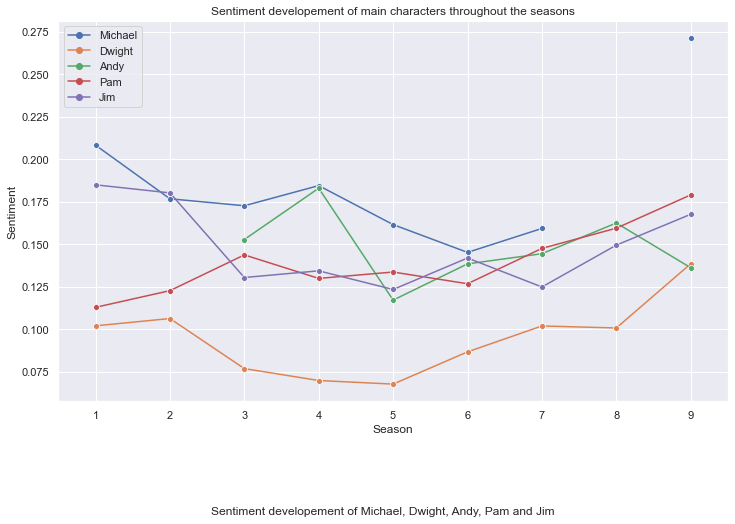

In [20]:
sns.set()
characters_sentiment = ["Michael", "Dwight", "Andy", "Pam", "Jim"]
sentiments = {character:get_sentiment_season(character) for character in characters_sentiment}
data = pd.DataFrame({character:sentiments[character]["sentiment"] for character in characters_sentiment}, index = list(range(1,10)))
title = "Sentiment developement of main characters throughout the seasons"
caption = "Sentiment developement of Michael, Dwight, Andy, Pam and Jim"
plt.figure(figsize=[12,7])
sns.lineplot(data=data, dashes=False, markers = ["o", "o", "o", "o", "o"])
plt.xlim(0.5,9.5)
plt.xlabel('Season')
plt.ylabel('Sentiment')
plt.title(title)
plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=12)
#plt.errorbar('Time', 'Latency', x=data., yerr=[x["std"] for x in sentiments.values()])
plt.savefig(folder + "character_sentiment_developement.png")
plt.show()

One can see that Dwight is the saddest, but he does get happier with the seasons. In the last seasons his career takes off and he becomes Regional Manager, his dream. He also marries Angela and discovers that her son is his. Finally, he inherits a farm. 

Pam also gets happier; she is at first not very happy either with her fiance Roy nor her position as a secretary. Both these things change; she ends up forming a family with Jim and having a job better suited to her potential.

Jim starts sentiment seems to decrease when he is rejected by Pam and moves to Stamford, but then increases as he forms a family with Pam and starts his dream job in Athlead.

Michael's sentiment also seems to decrease with the seasons, probably because of the multiple unfortunate events that happen to him. He looks happier in his last season, when he finally marries Holly.

Finally, Andy seems very happy in season 4, possibly because he is dating Angela and his sentiment has a noticable decrease in season 5, after he discovers Angela was cheating with Dwight all along.


Now let us look at the average sentiment of these characters per episode, in order to see if we can highlight some episodes which were particularly emotional for them. We do the same as before but we compute the sentiment for the lines in every episode.

In [21]:
episodes = set(zip(df_dialog.season,df_dialog.episode))

In [39]:
def get_sentiment_episode(character):
    episode_lines = un_pack_episode_lines(character)   
    sentiment = {}
    
    for episode in episodes:
        
        if episode not in episode_lines.keys():
                sentiment[episode] = None
        else:
            lines = episode_lines[episode]
            total = []
            analyzer = SentimentIntensityAnalyzer()       

            for sentence in lines:
                # compute the polarity score
                vs = analyzer.polarity_scores(sentence)
                total.append(vs["compound"])
            sentiment[episode] = sum(total)/len(lines)
            
    return dict(sorted(sentiment.items(), key=lambda item: item[0]))  

In [40]:
characters_sentiment = ["Michael", "Dwight", "Andy", "Pam", "Jim"]
sentiments = {character:get_sentiment_episode(character).values() for character in characters_sentiment}
data = pd.DataFrame({character:sentiments[character] for character in characters_sentiment}, index = range(len(list(episodes))))

Let us see what are the names of the episodes of the happiest and saddest episodes for each character. For this, wee need to look them up manually.

In [41]:
episodes_for_label = {}
for character in data.columns:
    sent_key = [(i,sentiment) for i,sentiment in get_sentiment_episode(character).items() if not pd.isna(sentiment) and (sentiment > 0.45 or sentiment < -0.1)]
    for i,sentiment in sent_key:
        episodes_for_label[sorted(list(episodes)).index(i)] = (i,sentiment)

In [42]:
episodes_for_label

{33: ((3, 6), -0.2160125),
 143: ((8, 5), -0.13397619047619047),
 56: ((4, 6), 0.45516666666666666),
 61: ((4, 11), 0.49395),
 72: ((5, 8), -0.11583333333333333),
 103: ((6, 13), -0.11572000000000002),
 45: ((3, 18), -0.11649375000000001),
 107: ((6, 17), 0.6613),
 130: ((7, 16), 0.742275),
 137: ((7, 23), -0.1723818181818182)}

In [51]:
labels = {
    33: "Diwali",
    45: "Cocktails",
    56: "Branch Wars",
    61: "Night Out",
    72: "Frame Toby",
    103: "Secret Santa",
    107: "The Delivery",
    130: "Threat Level Midnight",
    137: "Dwight K. Schrute, (Acting) Manager",
    143: "Spooked"
}

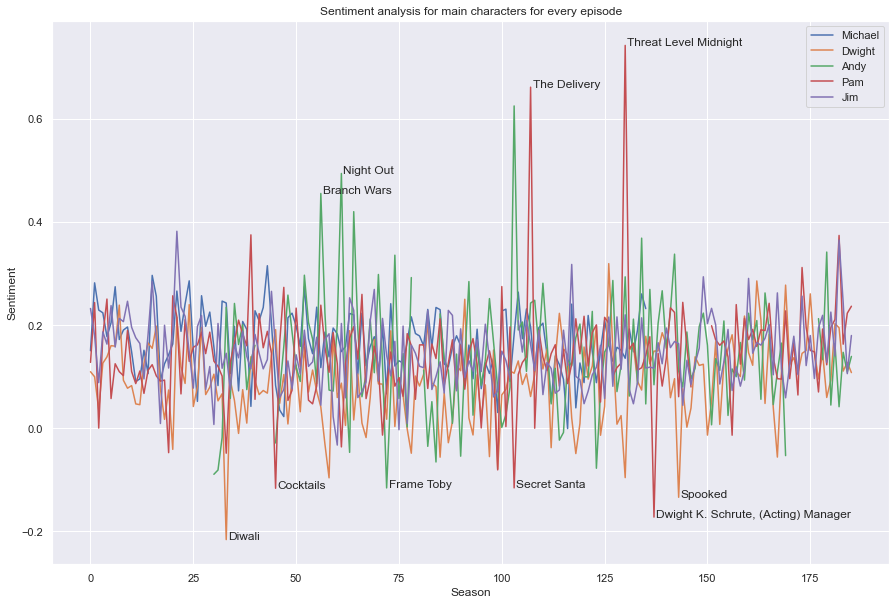

In [52]:
plt.figure(figsize=[15,10])
sns.lineplot(data=data, markers=False, dashes=False)
plt.xlabel('Season')
plt.ylabel('Sentiment')
plt.title("Sentiment analysis for main characters for every episode")
for x,label in labels.items():
    _,y = episodes_for_label[x]
    plt.annotate(label, (x + 0.5, y))
#plt.savefig(folder + "sentiment_per_episode_main.png")
plt.show()

There are a few episodes that had a high emotional load for Pam, Dwight and Andy, but we cannot observe any significant ones for Michael or Jim.

For Pam, she's happiest at `Threat Level Midnight`, where she has great fun watching Michael's movie, followed by `The Delivery`, where she gives birth to her first child with Jim. In contrast, she is saddest at `Dwight K. Schrute, (Acting) Manager`, where Dwight is named acting regional manager and terrorizes everyone, and `Cocktails`, where Roy gets furious at Pam.

For Dwight, the saddes moments are `Diwali`, where Michael´s girlfriend breaks up with him after he proposes. Since Dwight is Michael´s closest friend, he feels very sad for him. He is also sad is `Spooked`, where he is upset with Toby for removing the weapons from his Halloween costume.

Suprisingly, for Andy, `Spooked` is the episode where he is the happiest, where he organizes the Halloween party. He is also happy in `Night Out`, where he and Angela are voted the best couple. He is saddest at `Frame Toby`, where Angela keeps making unreasonable demands for their wedding.

## Emotional Stability of main characters

We also look at the boxplots for each characters' sentiments to analyze how emotionally stable they are - that is, how much their sentiment varies.

For this we just used the stream of sentiments per episode like we computed above, but for every main character, and then use it to plot boxplots with which we can visualize how appart the character´s sentiments are in every episode (emotional stability).

In [28]:
data = {character:get_sentiment_episode(character) for character in main_characters}
df = pd.DataFrame({character:episode.values() for character, episode in data.items()})

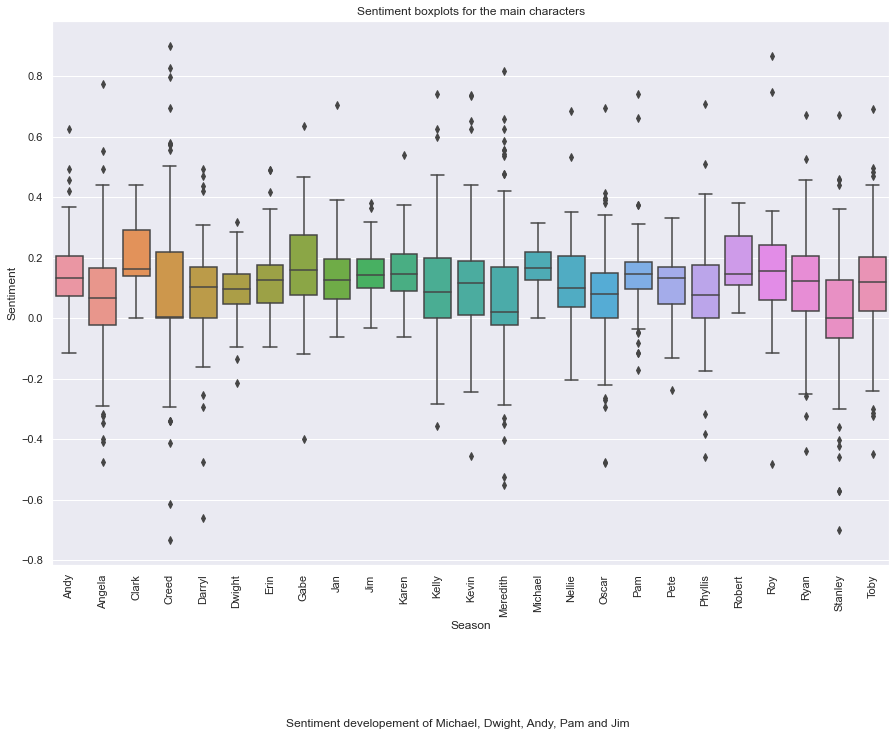

In [29]:
title = "Sentiment boxplots for the main characters"
#caption = "Sentiment boxplot for the main characters."
plt.figure(figsize=[15,10])
sns.boxplot(data=df, showmeans=False, meanprops={"marker":"x",
                       "markerfacecolor":"black", 
                       "markeredgecolor":"black",
                      "markersize":"10"})
plt.title(title)
plt.xticks(rotation=90)
plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=12)
plt.xlabel('Season')
plt.ylabel('Sentiment')
#plt.savefig(folder + "sentiment_distribution_boxplot.png")
plt.show()

We observe that there characters with low standard deviation and few outliers, such as `Michael`, `Dwight`, `Jim`, `Karen` or `Pam` and others with high standard deviation and many outliers, specially `Creed`, `Meredith` or `Stanley`. In general, we note that characters depicted as more unstable generally had less screentime and often appeared for particularly comical moments, which might explain their more exagerated reactions in more exageratic situations.

### Average sentiment per episode and season

Here we compute the sentiment for all the character's line for every episode and average it, to determine the overall happiest and saddest episodes.

In [30]:
sentiment_by_episode = {}

for episode in episodes:
    season,ep = episode
    
    df_ep = df_dialog[(df_dialog.season == season) & (df_dialog.episode == ep)]
    lines = df_ep.line_text
    
    total = []
    analyzer = SentimentIntensityAnalyzer()       

    for sentence in list(lines):
        # compute the polarity score
        vs = analyzer.polarity_scores(str(sentence))
        total.append(vs["compound"])
        
    sentiment_by_episode[episode] = sum(total)/len(lines)   
    
    sentiment_by_episode = dict(sorted(sentiment_by_episode.items(), key=lambda item: item[0], reverse = True))

In [31]:
sorted_ep = list(dict(sorted(sentiment_by_episode.items(), key=lambda item: item[1], reverse = True)).keys())

In [47]:
with open('Data/sentiment_episode.pickle', 'wb') as handle:
    pickle.dump(sentiment_by_episode, handle, protocol=pickle.HIGHEST_PROTOCOL)

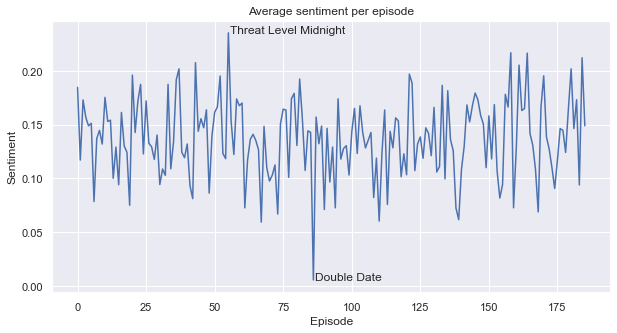

In [50]:
plt.figure(figsize=[10,5])
sns.lineplot(x = list(range(len(sentiment_by_episode))), y = sentiment_by_episode.values(), markers=False, dashes=False)
plt.xlabel('Episode')
plt.ylabel('Sentiment')
plt.title("Average sentiment per episode")
x = list(sentiment_by_episode.keys()).index((7,16))+ 0.5
y = sentiment_by_episode[(7,16)]
plt.annotate("Threat Level Midnight", (x, y))
x = list(sentiment_by_episode.keys()).index((6,9))+ 0.5
y = sentiment_by_episode[(6,9)]
plt.annotate("Double Date", (x, y))
#plt.savefig(folder + "avg_sentiment_episode.png")
plt.show()

The while the average sentiment per episode seems to very a lot, in general it was more stable across seasons. The happiest episode is `Threat Level Midnight`, (also the highest rated episode), where Michael finishes his movie, featuring several the office characters, where they are all very excited to see how it turned out. The saddest eppisode is `Double Date` where Jim, Pam, Michael and Pam´s mum go on a double date but Michael ends up breaking up with Pam´s mom because he finds her too old for him. Both her and Pam are furious for the rest of the episode.

Now we do the same but we average through the seasons.

In [33]:
print(f"The saddest episode is season {sorted_ep[0][0]}, episode {sorted_ep[0][1]}: PDA")
print(f"The happiest episode is season {sorted_ep[-1][0]}, episode {sorted_ep[-1][1]}: Double Date")

The saddest episode is season 7, episode 16: PDA
The happiest episode is season 6, episode 9: Double Date


In [34]:
sentiment_by_season = defaultdict(list)

for episode in episodes:
    season,ep = episode
    
    df_ep = df_dialog[(df_dialog.season == season) & (df_dialog.episode == ep)]
    lines = df_ep.line_text
    
    total = []
    analyzer = SentimentIntensityAnalyzer()       

    for sentence in list(lines):
        # compute the polarity score
        vs = analyzer.polarity_scores(str(sentence))
        total.append(vs["compound"])
        
    sentiment_by_season[season].append(sum(total)/len(lines))

In [35]:
sentiment_season_avg = {season:sum(lst)/len(lst) for (season,lst) in sentiment_by_season.items()}

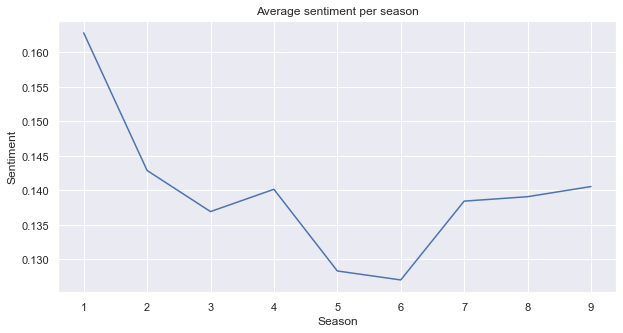

In [36]:
plt.figure(figsize=[10,5])
sns.lineplot(x = sentiment_season_avg.keys(), y = sentiment_season_avg.values())
plt.xlabel('Season')
plt.ylabel('Sentiment')
plt.title("Average sentiment per season")
plt.show()

The first season has a significantly possitive sentiment, and then it decreases. It has more negative sentiment during seasons 5 and 6.